# Classical Markowitz Portfolio Optimization (baseline + bridge to VQE)

This notebook implements **classical mean–variance portfolio optimization** (the Markowitz model)
as a **baseline** and an **educational introduction** for the VQE notebooks in this repository.

The goal is to make clear:
1) what portfolio optimisation is doing in classical terms (μ, Σ, λ, constraints),
2) what the efficient frontier represents, and
3) how the **Fractional VQE** and **Binary VQE** notebooks relate to the classical formulation.

## Model (long-only, fully-invested)

We solve, for a range of risk-aversion values λ:

$$
\min_{w \in \Delta}\; -\mu^\top w + \lambda\, w^\top \Sigma w,
\quad
\Delta = \{ w \in \mathbb{R}^n: w_i \ge 0,\ \sum_i w_i = 1\}.
$$

- $w$ are portfolio weights (allocations).
- $\mu$ is expected returns.
- $\Sigma$ is the covariance matrix (risk).
- $\lambda$ tunes the risk/return trade-off.

## Connection to the VQE notebooks

### Fractional VQE
Fractional VQE targets the *same objective* as above, but replaces the convex solver
with a hybrid quantum–classical loop. We still produce $w \in \Delta$, but in the
quantum model, weights are constructed from circuit readouts and explicitly **normalized**
to lie on the simplex.

### Binary VQE
Binary VQE solves a related *selection* problem with $x \in \{0,1\}^n$ and a cardinality
constraint $\sum_i x_i = K$. To compare against classical allocations, binary selections
can be mapped to allocations (e.g., equal-weight over the selected assets).

## Outputs
- λ-sweep allocations (grouped bar chart)
- Efficient frontier (risk vs return), colored by λ

## Dependencies
This notebook uses `cvxpy` for the classical convex optimization.
If needed:
```bash
pip install cvxpy
```

In [1]:
from __future__ import annotations

from pathlib import Path

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from vqe_portfolio.frontier import fractional_frontier_from_allocs
from vqe_portfolio.metrics import symmetrize
from vqe_portfolio.plotting import ensure_dir, plot_frontier, plot_lambda_sweep_bars

# Reproducibility (not strictly necessary for deterministic convex solves, but kept for consistency)
SEED = 0
np.random.seed(SEED)


def resolve_outdir() -> Path:
    """
    Choose an output directory that works whether the notebook is run:
    - from repo root, or
    - from within notebooks/.
    """
    if Path("notebooks").exists() and not Path("images").exists():
        return ensure_dir(Path("notebooks") / "images")
    return ensure_dir(Path("images"))


OUTDIR = resolve_outdir()

## Problem setup (toy example)

In [2]:
mu = np.array([0.10, 0.20, 0.15, 0.12], dtype=float)

Sigma = np.array(
    [
        [0.005, -0.010, 0.004, -0.002],
        [-0.010, 0.040, -0.002, 0.004],
        [0.004, -0.002, 0.023, 0.002],
        [-0.002, 0.004, 0.002, 0.018],
    ],
    dtype=float,
)

Sigma = symmetrize(Sigma)

n_assets = len(mu)
asset_labels = [f"Asset {i+1}" for i in range(n_assets)]

# λ sweep range
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)

## Solve Markowitz for each λ (cvxpy)

We solve:
$$
\min_w\; -\mu^\top w + \lambda\, w^\top \Sigma w
\quad \text{s.t.} \quad \sum_i w_i=1,\; w\ge0.
$$

This is a convex quadratic program. `cvxpy` handles the constraints explicitly.

In [3]:
allocations: list[np.ndarray] = []

for lam in lambdas:
    w = cp.Variable(n_assets)

    objective = cp.Minimize(-mu @ w + float(lam) * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)

    prob.solve(solver=cp.OSQP, verbose=False)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"CVXPY solve failed for λ={lam:.2f}: status={prob.status}")

    w_val = w.value
    if w_val is None:
        raise RuntimeError(f"Solver returned no solution for λ={lam:.2f}")

    # Numerical tolerance only
    if w_val.min() < -1e-6:
        raise RuntimeError(
            f"Unexpected negative weights for λ={lam:.2f}; min={w_val.min()}"
        )

    # Defensive cleanup (should be mostly unnecessary, but keeps reporting robust)
    w_val = np.maximum(w_val, 0.0)
    w_val = w_val / (w_val.sum() + 1e-12)

    allocations.append(w_val)

allocations = np.array(allocations, dtype=float)  # shape (L, n_assets)

## λ sweep plot (allocations)

Intuition:
- small λ emphasises return (riskier)
- large λ emphasises risk reduction (safer / more diversified)

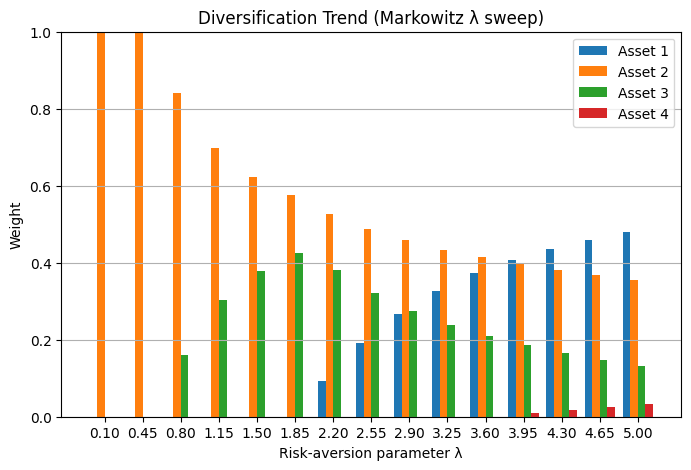

In [4]:
plot_lambda_sweep_bars(
    lambdas=lambdas,
    mat=allocations,
    asset_labels=asset_labels,
    ylabel="Weight",
    title="Diversification Trend (Markowitz λ sweep)",
    outpath=OUTDIR / "Markowitz_Lambda_Sweep.png",
)
plt.show()

## Efficient frontier (risk vs return) from λ sweep

Each λ yields an optimal allocation $w(\lambda)$. We compute:
- expected return $R(\lambda)=\mu^\top w(\lambda)$
- risk $\sigma(\lambda)=\sqrt{w(\lambda)^\top\Sigma w(\lambda)}$

We then sort points by risk and plot the frontier, colored by λ.

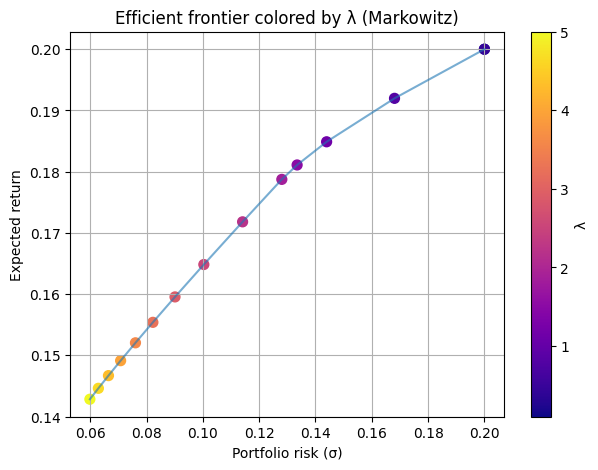

In [5]:
front = fractional_frontier_from_allocs(
    mu=mu,
    Sigma=Sigma,
    lambdas=lambdas,
    allocs_by_lambda=allocations,
    renormalize=True,
    sort_by="risk",
)

plot_frontier(
    risks=front.risks,
    returns=front.returns,
    lambdas_sorted=front.lambdas,
    title="Efficient frontier colored by λ (Markowitz)",
    outpath=OUTDIR / "Markowitz_Risk_Return_Colored.png",
)
plt.show()

## Next steps / comparison guidance

- **Closest quantum analogue:** `notebooks/Fractional_VQE.ipynb`
  - same objective, but weights come from a quantum circuit + normalization and are optimized by a hybrid loop.

- **Selection-based variant:** `notebooks/Binary_VQE.ipynb`
  - different decision variable (binary selection with cardinality constraint).
  - to compare against Markowitz, map the selected set to a classical allocation (e.g., equal-weight over Top-K).